<h1> Nombre: Matías</h1>
<h1> Apellido: Duhalde</h1>
<h1> Número de alumno: 18639496</h1>

# Problema de Regresión

# Pregunta 1

**Nota para el corrector**: Cambié un poco el "orden" de los pasos propuestos en la pregunta 1 y la 2. Hice el preprocesamiento de los datos en la parte 1, sin embargo, esto se pedía para la parte 2. Lo hice así porque me hacía mucho más sentido realizar este preprocesamiento ANTES de formar la matriz de características, debido a que de igual manera tendría que volver a reformularla después de hacer el preprocesamiento. En la issue [#197](https://github.com/UC-IIC2613/Syllabus/issues/197) se comenta que no hay problema en reordenar estas partes.

## Cargar Datos

In [12]:
# Imports para el análisis de datos
import pandas as pd
import numpy as np

# Se define el dataframe principal
diamonds_df = pd.read_csv('./diamonds.csv', index_col=0)

# Se muestra un resumen del dataframe
diamonds_df.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z,Usage
Unnamed: 0,,,,,,,,,,,
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,ToV
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,Test
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,ToV
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,ToV
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,ToV


## Análisis de los datos

Se propone la siguiente estrategia para preprocesar los datos:
- Reconocer posibles problemas en las filas, como por ejemplo, datos donde hayan valores nulos, o valores que no hagan mucho sentido
- Revisar la correlación que tienen los datos entre sí para poder determinar los datos más importantes para el precio, y modificarlos acorde a eso
- Convertir los datos de texto (strings) a valores numéricos
- Estandarizar/normalizar los datos

In [13]:
# Revisión general de las características del dataframe

print("-"*40, "SHAPE", "-"*40)
print(diamonds_df.shape)
print("-"*40, "INFO", "-"*40)
print(diamonds_df.info())
print("-"*40, "DESCRIBE", "-"*40)
print(diamonds_df.describe())
print("-"*40, "NULL VALUES", "-"*40)
print(diamonds_df.isnull().sum())
print("-"*40, "LABEL COLUMNS VALUE_COUNTS", "-"*40)
print(diamonds_df['cut'].value_counts())
print(diamonds_df['color'].value_counts())
print(diamonds_df['clarity'].value_counts())
print(diamonds_df['Usage'].value_counts())

---------------------------------------- SHAPE ----------------------------------------
(53940, 11)
---------------------------------------- INFO ----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
 10  Usage    53940 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 4.9+ MB
None
---------------------------------------- DESCRIBE ----------------------------------------
              carat         depth         table     

A partir del resumen anterior, se reconoce que existen filas donde los valores de `x`, `y`, o `z` son 0 (ver min de analisis anterior), lo cual no hace sentido, debido a que estos valores representan una dimensión de un objeto tridimensional, la cual físicamente no puede tener valor 0.

A continuación, se muestran las filas donde `x`, `y`, o `z` son 0.

Se decide dropear estas filas, debido a que son pocas y no se perdería mayor información en beneficio a la distribución de los datos.

In [14]:
diamonds_df.loc[(diamonds_df['x'] == 0) | (diamonds_df['y'] == 0) | (diamonds_df['z'] == 0)]

diamonds_df = diamonds_df[diamonds_df['x'] != 0]
diamonds_df = diamonds_df[diamonds_df['y'] != 0]
diamonds_df = diamonds_df[diamonds_df['z'] != 0]

diamonds_df.shape

(53920, 11)

A continuación, se analiza la correlación de los datos numéricos.

Observaciones:
- x, y, z están muy relacionadas entre sí
- x, y, z están muy relacionados con el carat
- carat es el atributo más relacionado con el precio (x, y, z lo siguen de cerca)
- depth y table no están muy relacionadas al precio (pero se puede apreciar que depth está ligeramente relacionada inversamente)
- x, y, z están relacionados en de forma mas o menos parecida al resto de todos los datos

In [15]:
diamonds_df.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028259,0.181646,0.921592,0.977779,0.953991,0.961048
depth,0.028259,1.000000,-0.295733,-0.010729,-0.025017,-0.029069,0.095023
table,0.181646,-0.295733,1.000000,0.127245,0.196097,0.184493,0.152483
price,0.921592,-0.010729,0.127245,1.000000,0.887231,0.867864,0.868206
x,0.977779,-0.025017,0.196097,0.887231,1.000000,0.974918,0.975435
y,0.953991,-0.029069,0.184493,0.867864,0.974918,1.000000,0.956744
z,0.961048,0.095023,0.152483,0.868206,0.975435,0.956744,1.000000


A continuación, se estudia la relación entre los datos discretos y el precio

<AxesSubplot:title={'center':'price'}, xlabel='cut'>

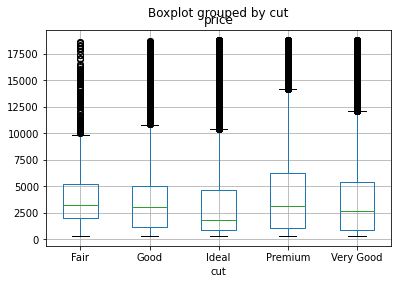

In [16]:
diamonds_df.boxplot(column="price", by='cut')

<AxesSubplot:title={'center':'price'}, xlabel='color'>

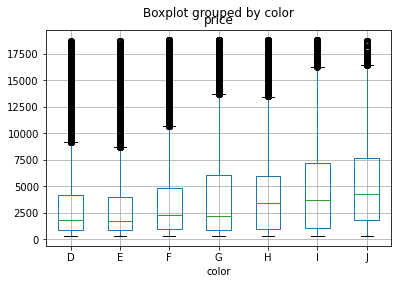

In [17]:
diamonds_df.boxplot(column="price", by='color')

<AxesSubplot:title={'center':'price'}, xlabel='clarity'>

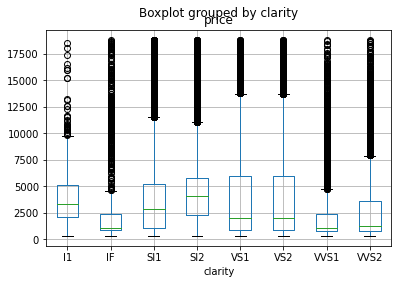

In [18]:
diamonds_df.boxplot(column="price", by='clarity')

De acuerdo a Wikipedia, los órdenes de calidad serían los siguientes (de más calidad a menos calidad):

- **Cut** : Ideal - Premium - Very good - Good - Fair
- **Color** : D - E - F - G - H - I - J
- **Clarity** : IF - VVS1 - VVS2 - VS1 - VS2 - SI1 - SI2 - I1

Fuentes:
- https://en.wikipedia.org/wiki/Diamond_cut
- https://en.wikipedia.org/wiki/Diamond_color
- https://en.wikipedia.org/wiki/Diamond_clarity


Se puede notar que no existe una relación directa en el dataset que estamos usando entre la calidad y el precio alto. De hecho, en los diagramas de caja se puede apreciar un efecto casi contrario. Esto es explicable porque generalmente los diamantes de "mejor calidad" (mejor color, corte, y claridad) tienden a ser más pequeño, y el factor que más influye en el precio final del diamante es el carat (peso). Diamantes grandes tienden a tener más imperfecciones que reducen su calidad, pero compensan en el precio por su alto carat.

Dado lo anterior, se usa la estrategia *One-Hot Encoding* para trabajar los valores no numéricos.


In [37]:
new_diamonds_df = pd.get_dummies(diamonds_df, columns=['cut', 'clarity', 'color'])
new_diamonds_df.head(5)

,carat,depth,table,price,x,y,z,Usage,cut_Fair,cut_Good,...,clarity_VS2,clarity_VVS1,clarity_VVS2,color_D,color_E,color_F,color_G,color_H,color_I,color_J
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,0.23,61.5,55.0,326,3.95,3.98,2.43,ToV,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.21,59.8,61.0,326,3.89,3.84,2.31,Test,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.23,56.9,65.0,327,4.05,4.07,2.31,ToV,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.29,62.4,58.0,334,4.20,4.23,2.63,ToV,0,0,...,1,0,0,0,0,0,0,0,1,0
5,0.31,63.3,58.0,335,4.34,4.35,2.75,ToV,0,1,...,0,0,0,0,0,0,0,0,0,1


También, sabemos que tanto depth como table corresponden a un porcentaje, por lo que podemos normalizar las características a valores entre 0 y 1

In [38]:
new_diamonds_df.depth = new_diamonds_df.depth / 100
new_diamonds_df.table = new_diamonds_df.table / 100

In [39]:
new_diamonds_df.head(5)

,carat,depth,table,price,x,y,z,Usage,cut_Fair,cut_Good,...,clarity_VS2,clarity_VVS1,clarity_VVS2,color_D,color_E,color_F,color_G,color_H,color_I,color_J
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,0.23,0.615,0.55,326,3.95,3.98,2.43,ToV,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.21,0.598,0.61,326,3.89,3.84,2.31,Test,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.23,0.569,0.65,327,4.05,4.07,2.31,ToV,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.29,0.624,0.58,334,4.20,4.23,2.63,ToV,0,0,...,1,0,0,0,0,0,0,0,1,0
5,0.31,0.633,0.58,335,4.34,4.35,2.75,ToV,0,1,...,0,0,0,0,0,0,0,0,0,1


In [81]:
# Resetear index
new_diamonds_df = new_diamonds_df.reset_index().drop('Unnamed: 0', axis=1)

A continuación, se construye la matriz de características

In [104]:
characteristics = new_diamonds_df.drop(['Usage', 'price'], axis=1).to_numpy()

new_dataframe = pd.DataFrame()
new_dataframe['X'] = [*characteristics]
new_dataframe['y'] = new_diamonds_df['price']
new_dataframe['Usage'] = new_diamonds_df['Usage']

new_dataframe.head(5)


,X,y,Usage
0,"[0.23, 0.615, 0.55, 3.95, 3.98, 2.43, 0.0, 0.0...",326,ToV
1,"[0.21, 0.598, 0.61, 3.89, 3.84, 2.31, 0.0, 0.0...",326,Test
2,"[0.23, 0.569, 0.65, 4.05, 4.07, 2.31, 0.0, 1.0...",327,ToV
3,"[0.29, 0.624, 0.58, 4.2, 4.23, 2.63, 0.0, 0.0,...",334,ToV
4,"[0.31, 0.633, 0.58, 4.34, 4.35, 2.75, 0.0, 1.0...",335,ToV


Luego, se separa el set de test del resto

In [111]:
df_test = new_dataframe[new_dataframe['Usage'] == 'Test']
df_tov = new_dataframe[new_dataframe['Usage'] == 'ToV']

In [143]:
X_test = np.stack(df_test['X'].to_numpy())
y_test = df_test['y'].to_numpy()

X_tov = np.stack(df_tov['X'].to_numpy())
y_tov = df_tov['y'].to_numpy()


### Formas de los sets

In [144]:
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)
print("X_tov shape", X_tov.shape)
print("y_tov shape", y_tov.shape)

X_test shape (5349, 26)
y_test shape (5349,)
X_tov shape (48571, 26)
y_tov shape (48571,)


# Pregunta 2

**Nota para el corrector**: tal como se especificó antes, el preprocesamiento se encuentra en la Parte 1, por lo que la Parte 2 se centra principalmente en dividir los sets.

# Pregunta 3

# Pregunta 4

# Problema de Aprendizaje Reforzado

#AR - demo

In [ ]:
#Descarga del ambiente (RUN ME!)
%%bash
pip install gym pyvirtualdisplay > /dev/null 2>&1
apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
apt-get update > /dev/null 2>&1
apt-get install cmake > /dev/null 2>&1
pip install --upgrade setuptools 2>&1
pip install ez_setup > /dev/null 2>&1
pip install gym[atari] > /dev/null 2>&1
pip3 install box2d-py

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (57.0.0)


In [20]:
#@title Importes (RUN ME TOO!)
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [21]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Vamos a inicializar el ambiente

In [22]:
env = gym.make('CartPole-v1')

Cada vez que se resetea el ambiente se envía una observación del estado en el que inicia la nueva instancia.

In [23]:
obs = env.reset()
print(obs)

[-0.04014774 -0.04082934  0.01923368 -0.02115453]


Estos son los estados de ciertas variables importantes, para el ambiente. En ese caso estamos utilizando el ambiente ```CartPole-v1```. Según la [wiki](https://github.com/openai/gym/wiki/CartPole-v0) del toolkit las observaciones del sistema son: <p>

>Num | Observations | Min | Max
>--- | --- | ---  | ---
>0 | Cart Position | -2.4 | 2.4
>1 | Cart Velocity | -Inf | Inf
>2 | Pole Angle | ~-41.8° | ~41.8°
>3 | Pole Velocity at tip | -Inf | Inf


In [24]:
print('Su espacio de acciones es', env.action_space)

Su espacio de acciones es Discrete(2)


En pocas palabras

>Num | Action
>--- | --- 
>0 | Push car to left
>1 | Push car to right

Cada vez que se carga el ambiente se inicializa en algún estado aleatorio, con el péndulo en posición vertical. Veamos dos ejemplos.

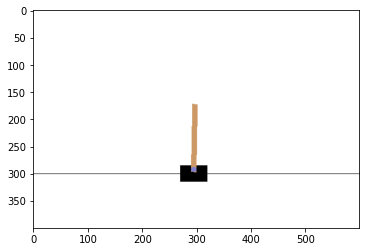

In [25]:
import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'));

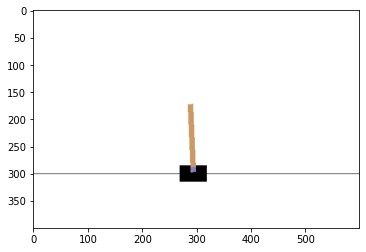

In [26]:
env.reset()
plt.imshow(env.render(mode='rgb_array'));

La diferencia es sutil, esto pues este ambiente tiene un desafío como diseño. Hay que mantener el péndulo vertical tanto como se pueda. Luego de eso el ambiente termina. <br>
Ambientes como éste se denominan episódicos. Y tienden a funcionar en series de episodios. Muchos juegos caen en esta categoría, juegos de atari como pacman, o incluso juegos analógicos como el ajedrés también son episódicos.<br>
Los episodios de este ambiente terminan si:


*   El ángulo del péndulo es mayor a $\pm 12°$
*   La posición del carro es mayor a $\pm 2.4$
*   El largo del episodio es mayor a 500



Cada ambiente puede enviar una secuencia de acciones aleatorias si se le desea.

In [27]:
[env.action_space.sample() for _ in range(10)]

[1, 1, 0, 1, 1, 1, 1, 1, 0, 0]

Calculemos cuantas acciones de "ir a la izquierda" puede tomar en promedio el sistema antes de que termine el episodio.

In [28]:
def actions_till_done(env, action):
    env.reset()
    done = False
    count = 0
    while done == False:
        _, _, done, _, = env.step(action)
        count += 1
    return count
  
# Get an estimate for how many 0 actions you can take on average before the 
# pole falls over
np.mean([actions_till_done(env, 0) for _ in range(100)])

9.37

De la misma manera se puede definir un criterio que calcule la cantidad de recompensas que se pueden obtener por episodio en promedio.

In [29]:
def average_episodic_return(env, agent, episodes=10, max_steps_per_episode=500):
    episode_rewards = []
    for episode in range(episodes):
        total_rewards = 0
        obs = env.reset()
        for t in range(max_steps_per_episode):
            out = agent(obs) # we don't care about the probabilities here
            assert ("Action" in out), "The key 'Action' was missing from the agents output."
            obs, rew, done, _ = env.step(out["Action"])
            total_rewards += rew
            # check if we are done, if so, exit loop
            if done:
                break
                
        episode_rewards.append(total_rewards)
        
    return {
        "AverageEpisodicReturn": np.mean(episode_rewards), 
        "StandardDeviation":np.sqrt(np.var(episode_rewards))
    }

In [30]:
def agent_left(observation):
    return {"Action":0}

In [31]:
average_episodic_return(env, agent_left)

{'AverageEpisodicReturn': 9.3, 'StandardDeviation': 0.7810249675906655}

De la misma forma que pudimos mostrar una imagen de un estado del agente se puede presentar al agente en una secuencia animada.

In [32]:
from collections import deque
import matplotlib.animation
import matplotlib.pyplot as plt
%matplotlib inline

def animate_agent(env, agent, max_steps = 400):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
            
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

¿Cómo se ve el agente cuando se le da la orden de ir siempre a la izquierda?

In [33]:
def agent_left(observation):
    return {"Action":0}
  
animate_agent(env, agent_left, max_steps = 400)

¿Y si se envía una orden aleatoria para que se mueva a izquierda o derecha?

In [40]:
def agent_random(observation):
    return {"Action":np.random.choice([0, 1])}

In [41]:
average_episodic_return(env, agent_random)

{'AverageEpisodicReturn': 23.5, 'StandardDeviation': 10.31746092796091}

In [42]:
animate_agent(env, agent_random)

Podemos definir una función que discretice el valor del estado en caso de que necesitasemos un valor en este dominio.

In [43]:
def state_for(observation):
    ranges = [np.arange(-1, 1.25, 0.25), np.arange(-0.3, 0.375, 0.075)[:9], np.arange(-1, 1.25, 0.25)]
    state = np.zeros((3,)) #Ignorando el primer sensor
    for i, (obs, limits) in enumerate(zip(observation[1:], ranges)):
        if obs < limits[0]:
            state[i] = 0
            continue
        for j in range(1, len(limits) - 1):
            if limits[j] <= obs <= limits[j+1]:
                state[i] = j
                break
        if obs > limits[len(limits) - 1]:  
            state[i] = len(limits)

    currstate = 0

    for i in range(3): 
        currstate += state[i] * (10 ** i)

    return int(currstate)


Este es un ejemplo del carro cuando ha sido entrenado correctamente un agente utilizando q learning.

In [39]:
animate_agent(env, agent)

NameError: name 'agent' is not defined

In [37]:
average_episodic_return(env, agent)

NameError: name 'agent' is not defined

#Pregunta 5

In [ ]:
env = gym.make('Pendulum-v0')

#Pregunta 6

#Pregunta 7 (BONO)